In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
38419,NaN,NaN,International,2020-08-18,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38420,NaN,NaN,International,2020-08-19,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38421,NaN,NaN,International,2020-08-20,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


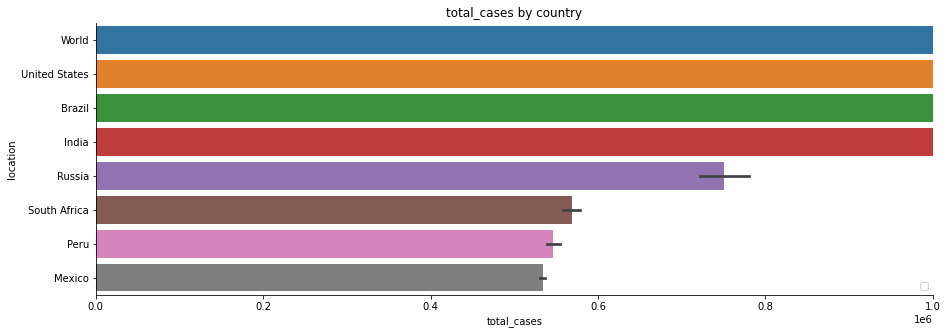

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


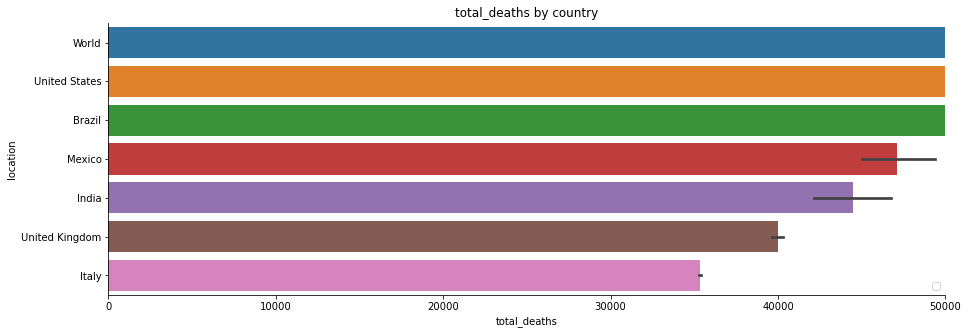

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


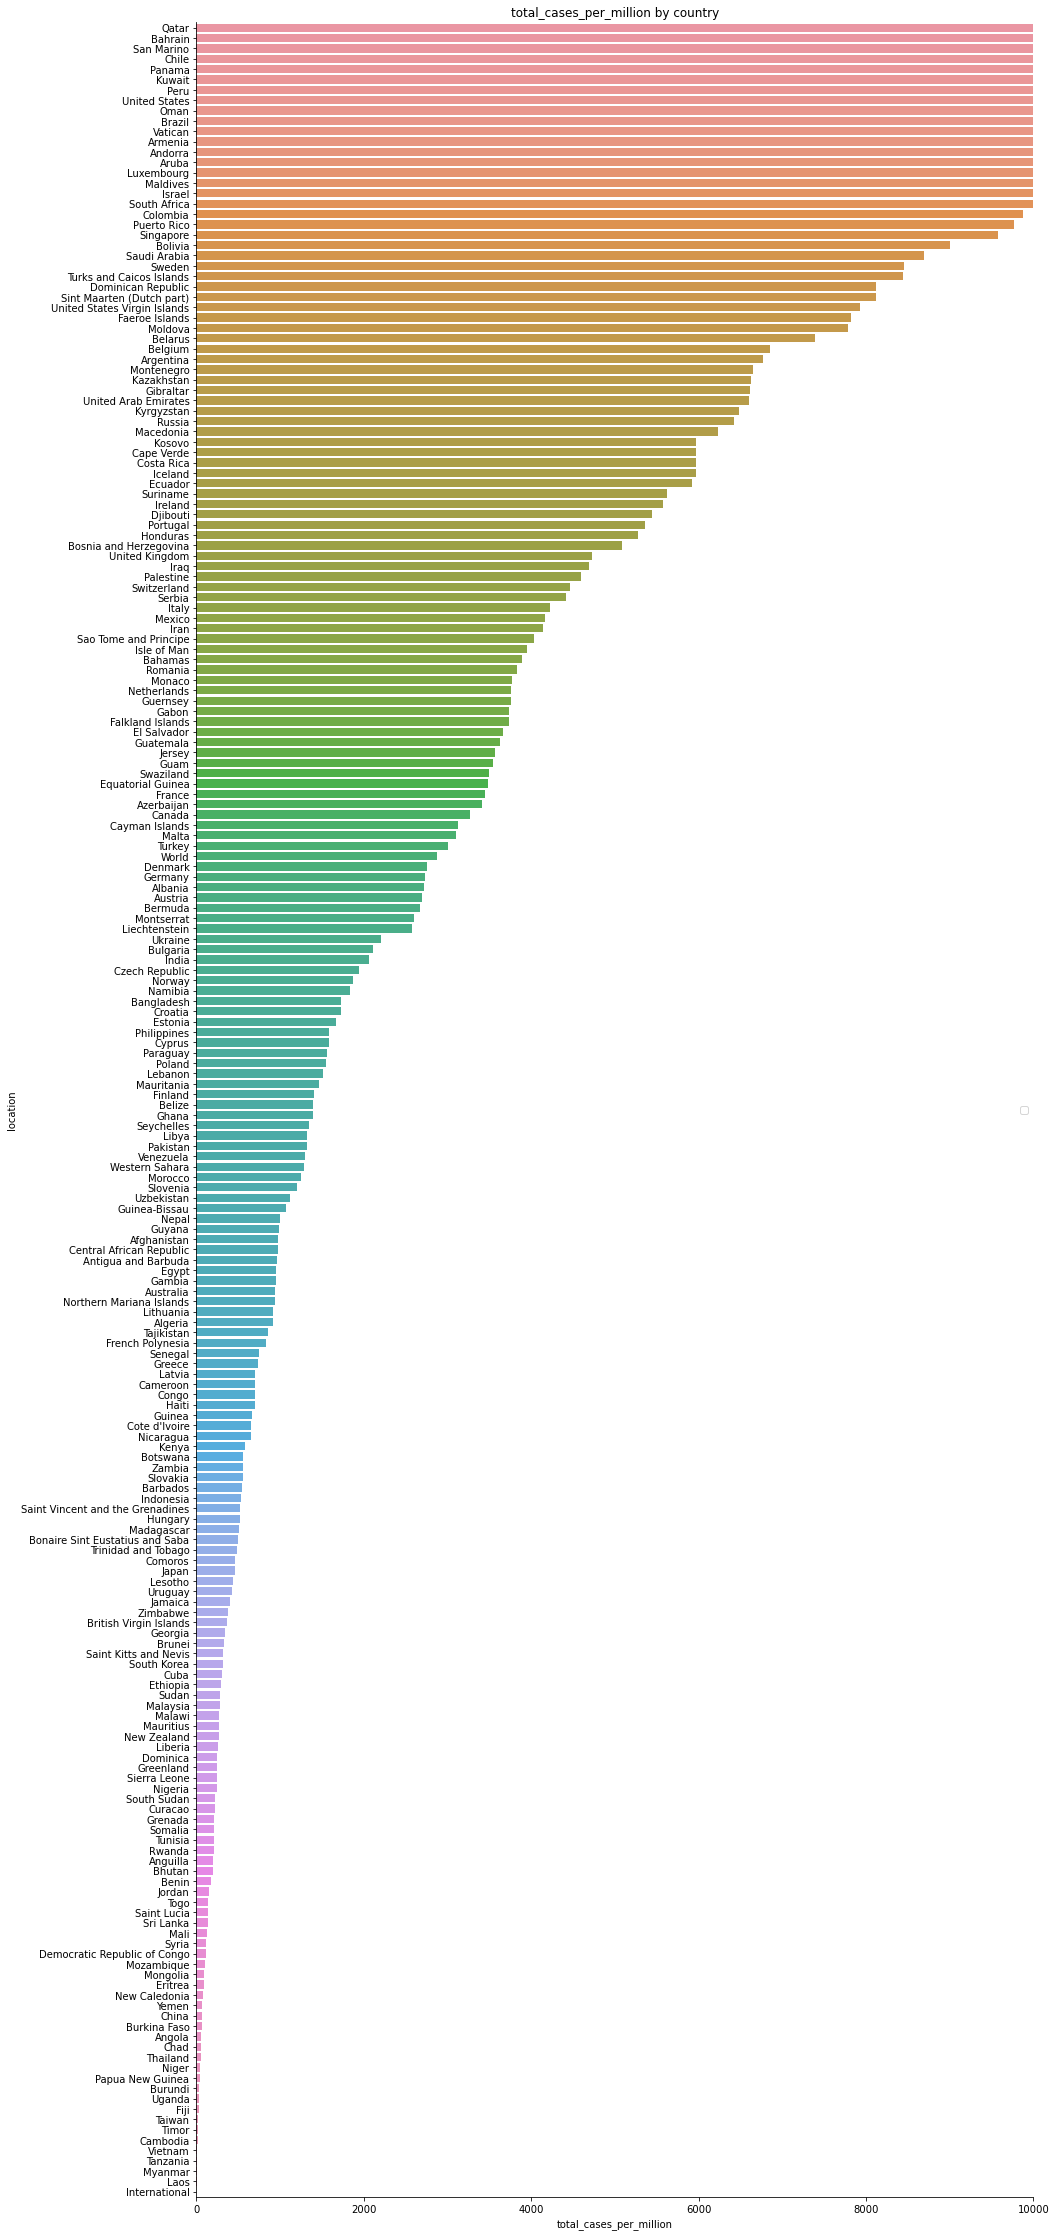

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


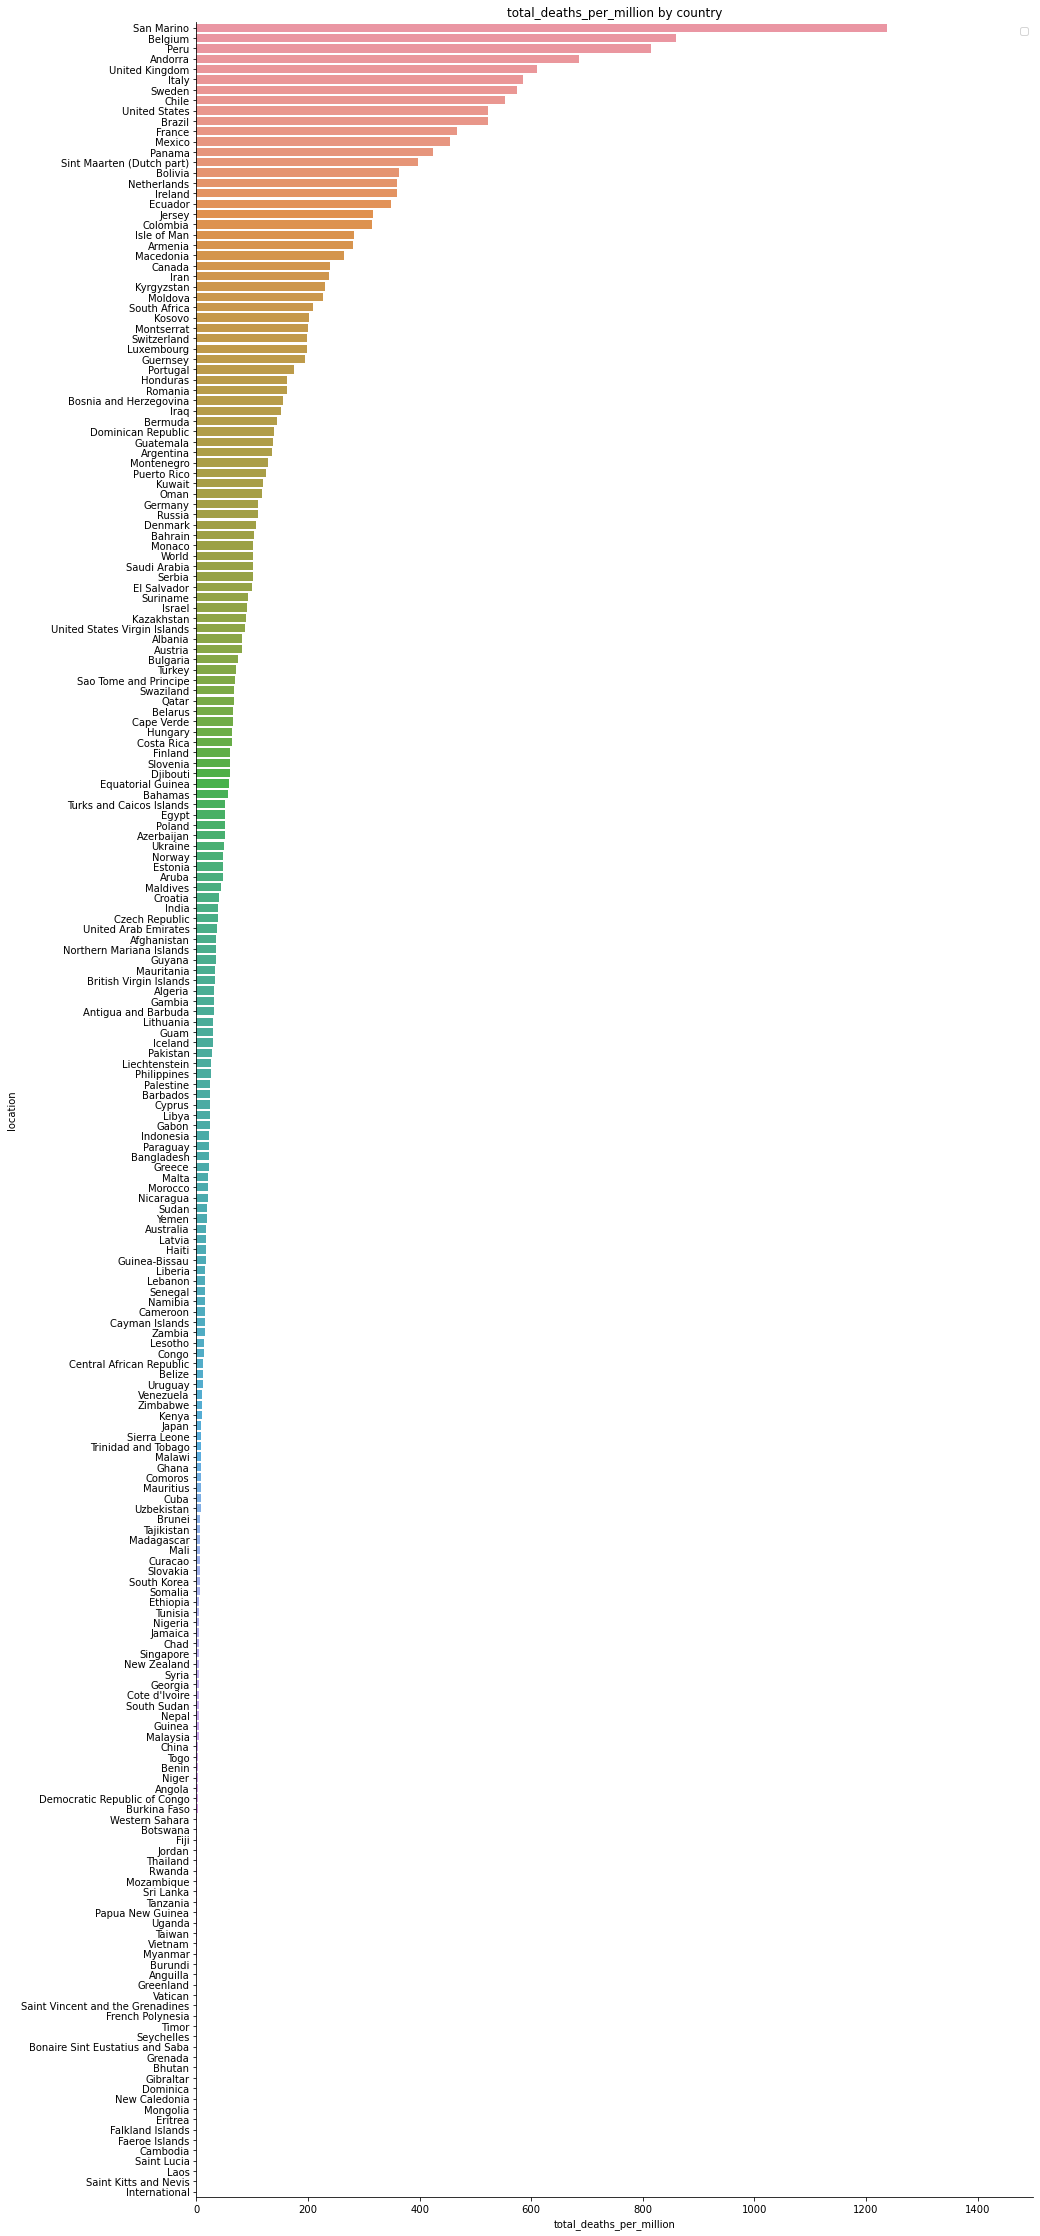

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

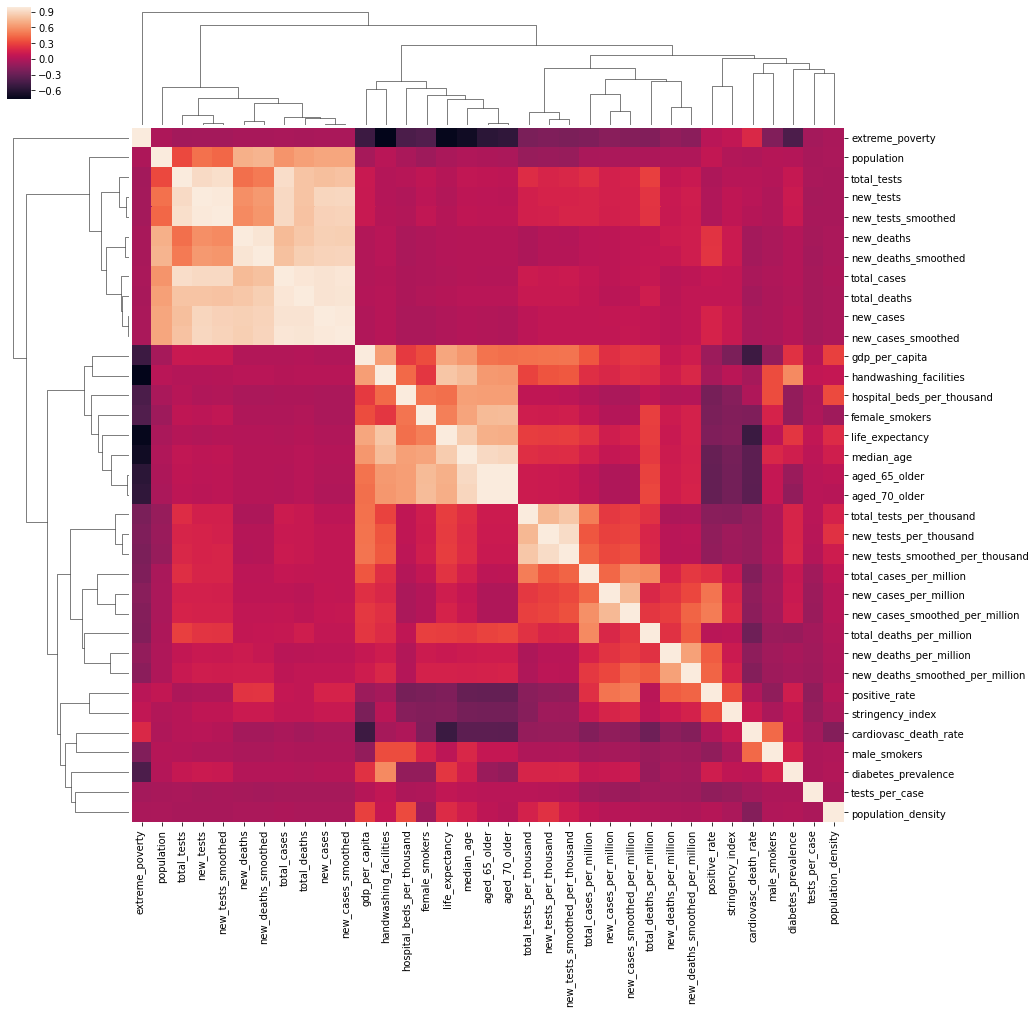

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995937591323228 (+/- 0.00021962983600405935)
Coef :  [1.04142656e+00 8.86632126e-05 9.40610649e-05]
3 Last_days :  [[21904227 22158534 22431929]]
Today :  22431929
Prediction + :  453853
Tomorow :  22885782
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994365703821706 (+/- 0.0002821426614360051)
Coef :  [-0.06430686  0.51892483  0.55535011]
3 Last_days :  [[774575 781259 787773]]
Today :  787773
Prediction + :  7513
Tomorow :  795286
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9881736904046506 (+/- 0.008028977393167923)
Coef :  [-0.66361462  0.72878009  0.93583481]
3 Last_days :  [[219029 221267 225043]]
Today :  225043
Prediction + :  1778
Tomorow :  226821
                                     
--------- Total Death -----------------
                                     
R^2: 0.38424412265634317 (+/- 0.8576263043695632)
Coef :  [-0.75484675  0.78845285  0.96550655]
3 Last_days :  [[30429 30451 30468]]
Today :  30468
Prediction + :  40
Tomorow :  30508
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8489845876119682 (+/- 0.10658092910908384)
Coef :  [-0.32212472 -0.02438465  1.34078031]
3 Last_days :  [[89441 89494 89527]]
Today :  89527
Prediction + :  44
Tomorow :  89571
                                     
--------- Total Death -----------------
                                     
R^2: -966.3090021844424 (+/- 1367.7387038679128)
Coef :  [-0.07666596  0.01241986  1.05626906]
3 Last_days :  [[4703 4705 4706]]
Today :  4706
Prediction + :  7
Tomorow :  4713
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.3595421332984035 (+/- 0.9043691958027981)
Coef :  [-0.83589961  0.90410303  0.93099384]
3 Last_days :  [[254235 254636 255278]]
Today :  255278
Prediction + :  458
Tomorow :  255736
                                     
--------- Total Death -----------------
                                     
R^2: 0.9103746032429655 (+/- 0.09702251122303945)
Coef :  [-0.83423508  0.90234073  0.93108514]
3 Last_days :  [[35400 35405 35412]]
Today :  35412
Prediction + :  26
Tomorow :  35438
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7763314725028998 (+/- 0.30461348091894236)
Coef :  [-0.69448016  0.57383405  1.12110291]
3 Last_days :  [[359082 364196 370867]]
Today :  370867
Prediction + :  4794
Tomorow :  375661
                                     
--------- Total Death -----------------
                                     
R^2: 0.2192991340791254 (+/- 0.9147622948048612)
Coef :  [-0.71831698  0.6110266   1.10632961]
3 Last_days :  [[28646 28670 28797]]
Today :  28797
Prediction + :  40
Tomorow :  28837
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9930064754279456 (+/- 0.009591744682725797)
Coef :  [0.07790553 0.46458485 0.47650651]
3 Last_days :  [[5438325 5482416 5529842]]
Today :  5529842
Prediction + :  87139
Tomorow :  5616981
                                     
--------- Total Death -----------------
                                     
R^2: 0.46797356406705376 (+/- 0.7509855743667379)
Coef :  [-0.61708201  0.76299154  0.85641664]
3 Last_days :  [[170497 171821 173177]]
Today :  173177
Prediction + :  1279
Tomorow :  174456
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9890953977591549 (+/- 0.014383952558476507)
Coef :  [-0.7788574   0.87572936  0.90320489]
3 Last_days :  [[319197 320286 321098]]
Today :  321098
Prediction + :  1231
Tomorow :  322329
                                     
--------- Total Death -----------------
                                     
R^2: 0.4234558023319614 (+/- 0.7900515990494844)
Coef :  [-0.77667319  0.83277503  0.94340783]
3 Last_days :  [[41369 41381 41397]]
Today :  41397
Prediction + :  48
Tomorow :  41445
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9859335497527981 (+/- 0.016887133842712884)
Coef :  [-0.81149737  0.86601458  0.94507362]
3 Last_days :  [[226145 226914 228621]]
Today :  228621
Prediction + :  731
Tomorow :  229352
                                     
--------- Total Death -----------------
                                     
R^2: 0.4240971368315898 (+/- 0.8020219931072767)
Coef :  [-0.796177    0.84241309  0.95317391]
3 Last_days :  [[9232 9243 9253]]
Today :  9253
Prediction + :  15
Tomorow :  9268
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.9067754536724966 (+/- 2.6958679184796823)
Coef :  [0.17508618 0.41987525 0.41765069]
3 Last_days :  [[345450 347835 347835]]
Today :  347835
Prediction + :  5189
Tomorow :  353024
                                     
--------- Total Death -----------------
                                     
R^2: 0.9008686245928063 (+/- 0.13984963684813978)
Coef :  [-0.02702837  0.52453703  0.51622605]
3 Last_days :  [[19804 19972 19972]]
Today :  19972
Prediction + :  321
Tomorow :  20293
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.998476827549969 (+/- 0.0018898363456423776)
Coef :  [-0.75676974  0.85724456  0.89672681]
3 Last_days :  [[250542 251805 253108]]
Today :  253108
Prediction + :  1095
Tomorow :  254203
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993818238752555 (+/- 0.0005463420296292176)
Coef :  [-0.82148417  0.89981216  0.91868289]
3 Last_days :  [[5996 6016 6039]]
Today :  6039
Prediction + :  17
Tomorow :  6056
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4571897945198858 (+/- 0.7648196005665913)
Coef :  [-0.19415813  0.50044161  0.71133919]
3 Last_days :  [[3359570 3407354 3456652]]
Today :  3456652
Prediction + :  59939
Tomorow :  3516591
                                     
--------- Total Death -----------------
                                     
R^2: 0.4987350320763264 (+/- 0.703596636032421)
Coef :  [-0.19517878  0.55260919  0.65567055]
3 Last_days :  [[108536 109888 111100]]
Today :  111100
Prediction + :  1497
Tomorow :  112597
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(22431929, 787773, 22885782, 795286),
 (225043, 30468, 226821, 30508),
 (255278, 35412, 255736, 35438),
 (370867, 28797, 375661, 28837),
 (5529842, 173177, 5616981, 174456),
 (89527, 4706, 89571, 4713),
 (321098, 41397, 322329, 41445),
 (228621, 9253, 229352, 9268),
 (347835, 19972, 353024, 20293),
 (253108, 6039, 254203, 6056),
 (3456652, 111100, 3516591, 112597)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-20,France,226821.0,0.0,30508.0,0.0,0.0,0.0
0,2020-08-20,China,89571.0,0.0,4713.0,0.0,0.0,0.0
0,2020-08-20,Italy,255736.0,0.0,35438.0,0.0,0.0,0.0
0,2020-08-20,Spain,375661.0,0.0,28837.0,0.0,0.0,0.0
0,2020-08-20,United States,5616981.0,0.0,174456.0,0.0,0.0,0.0
0,2020-08-20,World,22885782.0,0.0,795286.0,0.0,0.0,0.0
0,2020-08-20,United Kingdom,322329.0,0.0,41445.0,0.0,0.0,0.0
0,2020-08-20,Germany,229352.0,0.0,9268.0,0.0,0.0,0.0
0,2020-08-20,Iran,353024.0,0.0,20293.0,0.0,0.0,0.0
0,2020-08-20,Turkey,254203.0,0.0,6056.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")